# ChEMBL Data Filtering Pipeline

This notebook filters ChEMBL bioactivity data using:
1. **Quality filters** from the overlapping IC50s paper
2. **Lipinski's Rule of 5** for drug-like molecules

**Input:** `data/raw/` - Per-UniProt ChEMBL activity files  
**Output:** `data/chembl_filtered.parquet` - Filtered bioactivity data

## 1. Import Required Libraries

In [64]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Import RDKit for Lipinski property calculations
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Lipinski
    RDKIT_AVAILABLE = True
    print("✓ RDKit imported successfully for molecular property calculations")
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠ RDKit not available - will use existing Lipinski properties only")

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

✓ RDKit imported successfully for molecular property calculations
Libraries imported successfully!


## 2. Load Raw ChEMBL Data

Load all ChEMBL activity data from the `data/raw/` directory (per-UniProt parquet files).

In [65]:
# Define paths
raw_data_dir = Path('data/raw')
output_file = Path('data/chembl_filtered.parquet')
output_file.parent.mkdir(parents=True, exist_ok=True)

# Find all ChEMBL activity parquet files
activity_files = list(raw_data_dir.glob('uniprot_*/*_chembl_activities.parquet'))

print(f"Found {len(activity_files)} UniProt activity files")
print(f"Example: {activity_files[0] if activity_files else 'None'}")

Found 361 UniProt activity files
Example: data/raw/uniprot_B1YNX3/B1YNX3_chembl_activities.parquet


In [66]:
# Load all activity data
print("Loading ChEMBL activity data...")
all_activities = []

for i, file in enumerate(activity_files):
    if (i + 1) % 100 == 0:
        print(f"  Loaded {i + 1}/{len(activity_files)} files...")
    
    try:
        df = pd.read_parquet(file)
        all_activities.append(df)
    except Exception as e:
        print(f"  Error loading {file}: {e}")

# Combine all data
df_all = pd.concat(all_activities, ignore_index=True)

print(f"\n✓ Loaded {len(df_all):,} total activities")
print(f"  Unique compounds: {df_all['molecule_chembl_id'].nunique():,}")
print(f"  Unique UniProt IDs: {df_all['source_uniprot_id'].nunique():,}")
print(f"  Unique assays: {df_all['assay_chembl_id'].nunique():,}")
print(f"\nDataFrame shape: {df_all.shape}")
print(f"Memory usage: {df_all.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Loading ChEMBL activity data...
  Loaded 100/361 files...
  Loaded 100/361 files...
  Loaded 200/361 files...
  Loaded 200/361 files...
  Loaded 300/361 files...
  Loaded 300/361 files...

✓ Loaded 1,083,000 total activities
  Unique compounds: 1,499
  Unique UniProt IDs: 361
  Unique assays: 631

DataFrame shape: (1083000, 58)

✓ Loaded 1,083,000 total activities
  Unique compounds: 1,499
  Unique UniProt IDs: 361
  Unique assays: 631

DataFrame shape: (1083000, 58)
Memory usage: 2334.6 MB
Memory usage: 2334.6 MB


## 3. Initial Data Exploration

In [67]:
# Display first few rows
print("Sample of raw data:")
display(df_all.head())

# Check data types and missing values
print("\n" + "="*80)
print("Column Information:")
print("="*80)
info_df = pd.DataFrame({
    'Column': df_all.columns,
    'Non-Null Count': [df_all[col].notna().sum() for col in df_all.columns],
    'Null Count': [df_all[col].isna().sum() for col in df_all.columns],
    'Dtype': [df_all[col].dtype for col in df_all.columns]
})
display(info_df)

Sample of raw data:


,molecule_chembl_id,compound_key,canonical_smiles,molecule_pref_name,standard_type,standard_value,standard_units,standard_relation,standard_text_value,pchembl_value,activity_comment,data_validity_comment,assay_chembl_id,assay_description,assay_type,assay_organism,assay_category,assay_tax_id,assay_strain,assay_tissue,assay_cell_type,assay_subcellular_fraction,assay_tissue_chembl_id,assay_cell_chembl_id,assay_parameters,assay_variant_accession,assay_variant_mutation,bao_label,bao_format,bao_format_id,target_chembl_id,target_pref_name,target_organism,target_type,document_chembl_id,document_journal,document_year,doc_type,source_description,src_id,uo_units,ligand_efficiency_bei,ligand_efficiency_le,ligand_efficiency_lle,ligand_efficiency_sei,potential_duplicate,molecule_max_phase,molecular_weight,alogp,num_ro5_violations,confidence_score,record_id,activity_id,parent_molecule_chembl_id,activity_properties,action_type,value,source_uniprot_id
0,CHEMBL113081,None,c1ccc(-c2nc3c(-c4nc5ccccc5o4)cccc3o2)cc1,None,IC50,100000.0,nM,>,None,None,None,None,CHEMBL663853,Inhibitory concentration against human DNA top...,B,None,None,None,None,None,None,None,None,None,None,None,None,single protein format,BAO_0000357,None,CHEMBL1806,DNA topoisomerase 2-alpha,Homo sapiens,None,CHEMBL1137930,Bioorg Med Chem Lett,2004,None,None,1,UO_0000065,None,None,None,None,0,None,None,None,None,None,206172,31863,CHEMBL113081,None,None,100.0,B1YNX3
1,CHEMBL324340,None,Cc1ccc2oc(-c3cccc(N4C(=O)c5ccc(C(=O)O)cc5C4=O)...,None,IC50,2500.0,nM,=,None,5.60,None,None,CHEMBL872937,In vivo inhibitory activity against human Hepa...,B,None,None,None,None,None,None,None,None,None,None,None,None,organism-based format,BAO_0000218,None,CHEMBL3921,Heparanase,Homo sapiens,None,CHEMBL1146658,Bioorg Med Chem Lett,2004,None,None,1,UO_0000065,None,None,None,None,0,None,None,None,None,None,208970,31864,CHEMBL324340,None,None,2.5,B1YNX3
2,CHEMBL109600,None,COc1ccccc1-c1ccc2oc(-c3ccc(OC)c(N4C(=O)c5ccc(C...,None,IC50,9000.0,nM,=,None,5.05,None,None,CHEMBL872937,In vivo inhibitory activity against human Hepa...,B,None,None,None,None,None,None,None,None,None,None,None,None,organism-based format,BAO_0000218,None,CHEMBL3921,Heparanase,Homo sapiens,None,CHEMBL1146658,Bioorg Med Chem Lett,2004,None,None,1,UO_0000065,None,None,None,None,0,None,None,None,None,None,208987,31866,CHEMBL109600,None,None,9.0,B1YNX3
3,CHEMBL152968,None,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...,None,IC50,6000.0,nM,=,None,5.22,None,None,CHEMBL666153,Inhibition of cytochrome P450 1A2 of isolated ...,A,None,None,None,None,None,None,None,None,None,None,None,None,single protein format,BAO_0000357,None,CHEMBL3356,Cytochrome P450 1A2,Homo sapiens,None,CHEMBL1148425,Bioorg Med Chem Lett,2004,None,None,1,UO_0000065,None,None,None,None,0,None,None,None,None,None,297580,31874,CHEMBL152968,None,None,6.0,B1YNX3
4,CHEMBL152968,None,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...,None,IC50,37000.0,nM,=,None,4.43,None,None,CHEMBL665756,Inhibition of cytochrome P450 3A4 of isolated ...,A,None,None,None,None,None,None,None,None,None,None,None,None,single protein format,BAO_0000357,None,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,None,CHEMBL1148425,Bioorg Med Chem Lett,2004,None,None,1,UO_0000065,None,None,None,None,0,None,None,None,None,None,297580,31875,CHEMBL152968,None,None,37.0,B1YNX3



Column Information:


,Column,Non-Null Count,Null Count,Dtype
0,molecule_chembl_id,1083000,0,object
1,compound_key,0,1083000,object
2,canonical_smiles,1075780,7220,object
3,molecule_pref_name,83030,999970,object
4,standard_type,1083000,0,object
5,standard_value,1049427,33573,object
6,standard_units,1083000,0,object
7,standard_relation,1049066,33934,object
8,standard_text_value,0,1083000,object
9,pchembl_value,835715,247285,object


In [68]:
# Check standard_type distribution
print("\nStandard Type Distribution:")
print(df_all['standard_type'].value_counts())

# Check standard_relation distribution
print("\nStandard Relation Distribution:")
print(df_all['standard_relation'].value_counts())

# Check confidence_score distribution
print("\nConfidence Score Distribution:")
print(df_all['confidence_score'].value_counts(dropna=False))


Standard Type Distribution:
standard_type
IC50    626335
Ki      354141
EC50     90611
Kd       11913
Name: count, dtype: int64

Standard Relation Distribution:
standard_relation
=     894558
>     144761
<       7942
~        722
>=       722
<=       361
Name: count, dtype: int64

Confidence Score Distribution:
confidence_score
None    1083000
Name: count, dtype: int64


In [69]:
df_all['confidence_score']

0          None
1          None
2          None
3          None
4          None
           ... 
1082995    None
1082996    None
1082997    None
1082998    None
1082999    None
Name: confidence_score, Length: 1083000, dtype: object

## 4. Apply Quality Filters (From Overlapping IC50s Paper)

Apply the following filters based on the overlapping IC50s paper methodology:
- **pchembl_value**: Must be present (not null)
- **standard_type**: IC50, Ki, Kd, or EC50
- **standard_relation**: Must be '=' (exact measurement)
- **data_validity_comment**: Must be null (valid data)
- **confidence_score**: Must be 9 (high confidence)
- **Mutants/Variants**: Remove assays with mutant or variant mentions in description

In [70]:
# Store filtering statistics
filter_stats = {}
filter_stats['initial'] = len(df_all)

print("="*80)
print("QUALITY FILTERING")
print("="*80)
print(f"\nInitial activities: {len(df_all):,}")

# Filter 1: pchembl_value must be present
df_filtered = df_all[df_all['pchembl_value'].notna()].copy()
filter_stats['after_pchembl'] = len(df_filtered)
print(f"After pchembl_value filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# Convert pchembl_value to numeric (it may be stored as string)
df_filtered['pchembl_value'] = pd.to_numeric(df_filtered['pchembl_value'], errors='coerce')
df_filtered = df_filtered[df_filtered['pchembl_value'].notna()]
print(f"After converting to numeric: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# Filter 2: standard_type must be IC50, Ki, Kd, or EC50
valid_types = ['IC50', 'Ki', 'Kd', 'EC50']
df_filtered = df_filtered[df_filtered['standard_type'].isin(valid_types)]
filter_stats['after_standard_type'] = len(df_filtered)
print(f"After standard_type filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# Filter 3: standard_relation must be '='
df_filtered = df_filtered[df_filtered['standard_relation'] == '=']
filter_stats['after_relation'] = len(df_filtered)
print(f"After standard_relation filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# Filter 4: data_validity_comment must be null (valid data)
df_filtered = df_filtered[df_filtered['data_validity_comment'].isna()]
filter_stats['after_validity'] = len(df_filtered)
print(f"After data validity filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# # Filter 5: confidence_score must be 9 (high confidence)
# df_filtered = df_filtered[df_filtered['confidence_score'] == 9]
# filter_stats['after_confidence'] = len(df_filtered)
# print(f"After confidence score filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")

# # Filter 6: Remove mutants/variants based on assay description
# # Check for mutant, mutation, variant in assay description (case-insensitive)
# if 'assay_description' in df_filtered.columns:
#     mutant_keywords = ['mutant', 'mutation', 'variant']
#     mutant_mask = df_filtered['assay_description'].fillna('').str.lower().str.contains('|'.join(mutant_keywords), regex=True)
#     df_filtered = df_filtered[~mutant_mask]
#     filter_stats['after_mutant'] = len(df_filtered)
#     print(f"After mutant/variant filter: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")
# else:
#     print("Warning: 'assay_description' column not found, skipping mutant filter")
#     filter_stats['after_mutant'] = len(df_filtered)

# print(f"\n✓ Quality filtering complete")
# print(f"  Retained: {len(df_filtered):,} / {len(df_all):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")
# print(f"  Removed: {len(df_all) - len(df_filtered):,} ({(len(df_all) - len(df_filtered))/len(df_all)*100:.1f}%)")

QUALITY FILTERING

Initial activities: 1,083,000
After pchembl_value filter: 835,715 (77.2%)
After pchembl_value filter: 835,715 (77.2%)
After converting to numeric: 835,715 (77.2%)
After converting to numeric: 835,715 (77.2%)
After standard_type filter: 835,715 (77.2%)
After standard_relation filter: 835,715 (77.2%)
After standard_type filter: 835,715 (77.2%)
After standard_relation filter: 835,715 (77.2%)
After data validity filter: 835,715 (77.2%)
After data validity filter: 835,715 (77.2%)


## 4.5. Remove Duplicates (From Overlapping IC50s Paper)

Following the overlapping IC50s paper methodology, we need to remove duplicates:
1. **Same Document Duplicates**: Remove duplicate activities from the same publication (document_chembl_id)
2. **Same Molecule-Assay Duplicates**: When multiple measurements exist for the same compound-assay combination, keep only one (typically the median or most recent)

In [71]:
# Start with quality-filtered data
df_dedup = df_filtered.copy()

print("="*80)
print("DEDUPLICATION (Following Overlapping IC50s Paper Methodology)")
print("="*80)
print(f"\nStarting with {len(df_dedup):,} quality-filtered activities")

# Step 1: Generate assay conditions hash
# The overlapping paper creates an MD5 hash of assay experimental conditions
# to ensure only assays with identical conditions are grouped together
print("\nStep 1: Generate assay conditions hash")
print("  Creating hash from: assay_type, assay_organism, assay_category, assay_tax_id,")
print("                      assay_strain, assay_tissue, assay_cell_type, assay_subcellular_fraction,")
print("                      bao_format, variant_id")

# Check which assay condition columns exist
assay_condition_cols = [
    'assay_type', 'assay_organism', 'assay_category', 'assay_tax_id',
    'assay_strain', 'assay_tissue', 'assay_cell_type', 'assay_subcellular_fraction',
    'bao_format', 'variant_id'
]
existing_cols = [col for col in assay_condition_cols if col in df_dedup.columns]
print(f"  Found {len(existing_cols)}/{len(assay_condition_cols)} columns: {existing_cols}")

if len(existing_cols) > 0:
    # Create assay conditions hash
    import hashlib
    
    def create_assay_hash(row):
        # Concatenate all assay condition values (converting None to empty string)
        condition_str = '|'.join([str(row[col]) if pd.notna(row[col]) else '' for col in existing_cols])
        return hashlib.md5(condition_str.encode()).hexdigest()
    
    df_dedup['assay_conditions_hash'] = df_dedup.apply(create_assay_hash, axis=1)
    print(f"  Generated {df_dedup['assay_conditions_hash'].nunique():,} unique assay condition combinations")
else:
    print("  Warning: No assay condition columns found, using assay_chembl_id as proxy")
    df_dedup['assay_conditions_hash'] = df_dedup['assay_chembl_id']

# Step 2: Document-level deduplication (keep largest assay per target-document pair)
# This matches: "distinct on (tid, doc_id)" from overlapping paper
if 'doc_id' in df_dedup.columns and 'target_chembl_id' in df_dedup.columns:
    print("\nStep 2: Document-level deduplication (keep largest assay per target-document)")
    
    # Count activities per assay
    assay_sizes = df_dedup.groupby(['assay_chembl_id', 'target_chembl_id', 'doc_id']).size().reset_index(name='assay_size')
    df_dedup = df_dedup.merge(assay_sizes, on=['assay_chembl_id', 'target_chembl_id', 'doc_id'])
    
    # For each target-document pair, keep only the largest assay
    before_doc = len(df_dedup)
    df_dedup = df_dedup.sort_values('assay_size', ascending=False)
    df_dedup = df_dedup.drop_duplicates(subset=['target_chembl_id', 'doc_id'], keep='first')
    df_dedup = df_dedup.drop(columns=['assay_size'])
    
    print(f"  Before: {before_doc:,} activities")
    print(f"  After:  {len(df_dedup):,} activities")
    print(f"  Removed: {before_doc - len(df_dedup):,} ({(before_doc - len(df_dedup))/before_doc*100:.1f}%)")
else:
    print("\nStep 2: Skipped (doc_id or target_chembl_id not found)")

# Step 3: Remove exact duplicates (same molecule-assay-value)
print("\nStep 3: Remove exact molecule-assay-value duplicates")
before_exact = len(df_dedup)
df_dedup = df_dedup.drop_duplicates(
    subset=['molecule_chembl_id', 'assay_chembl_id', 'pchembl_value'],
    keep='first'
)
print(f"  Before: {before_exact:,} activities")
print(f"  After:  {len(df_dedup):,} activities")
print(f"  Removed: {before_exact - len(df_dedup):,} ({(before_exact - len(df_dedup))/before_exact*100:.1f}%)")

# Step 4: Handle replicates (same molecule-assay with different values)
# Keep the measurement closest to the median pchembl_value
print("\nStep 4: Handle replicates (keep measurement closest to median)")
mol_assay_counts = df_dedup.groupby(['molecule_chembl_id', 'assay_chembl_id']).size()
replicates = mol_assay_counts[mol_assay_counts > 1]
print(f"  Found {len(replicates):,} molecule-assay pairs with multiple values")

if len(replicates) > 0:
    before_replicates = len(df_dedup)
    
    # Identify replicates
    duplicate_mask = df_dedup.duplicated(subset=['molecule_chembl_id', 'assay_chembl_id'], keep=False)
    duplicates = df_dedup[duplicate_mask].copy()
    non_duplicates = df_dedup[~duplicate_mask].copy()
    
    print(f"  Processing {len(duplicates):,} replicate activities...")
    
    # Calculate median pchembl_value for each replicate group
    medians = duplicates.groupby(['molecule_chembl_id', 'assay_chembl_id'])['pchembl_value'].median()
    
    # Add median and calculate distance
    duplicates = duplicates.merge(
        medians.reset_index().rename(columns={'pchembl_value': 'median_pchembl'}),
        on=['molecule_chembl_id', 'assay_chembl_id']
    )
    duplicates['distance_to_median'] = (duplicates['pchembl_value'] - duplicates['median_pchembl']).abs()
    
    # Keep the measurement closest to median
    idx_to_keep = duplicates.groupby(['molecule_chembl_id', 'assay_chembl_id'])['distance_to_median'].idxmin()
    duplicates_to_keep = duplicates.loc[idx_to_keep].drop(columns=['median_pchembl', 'distance_to_median'])
    
    # Combine
    df_dedup = pd.concat([non_duplicates, duplicates_to_keep], ignore_index=True)
    
    print(f"  Before: {before_replicates:,} activities")
    print(f"  After:  {len(df_dedup):,} activities")
    print(f"  Removed: {before_replicates - len(df_dedup):,} ({(before_replicates - len(df_dedup))/before_replicates*100:.1f}%)")
else:
    print("  No replicates to process")

filter_stats['after_dedup'] = len(df_dedup)
print(f"\n✓ Deduplication complete: {len(df_dedup):,} unique activities")
print(f"  Unique target-condition combinations: {df_dedup.groupby(['target_chembl_id', 'assay_conditions_hash']).ngroups:,}")
print(f"  Overall retention from quality filtering: {len(df_dedup)/len(df_filtered)*100:.1f}%")

DEDUPLICATION (Following Overlapping IC50s Paper Methodology)

Starting with 835,715 quality-filtered activities

Step 1: Generate assay conditions hash
  Creating hash from: assay_type, assay_organism, assay_category, assay_tax_id,
                      assay_strain, assay_tissue, assay_cell_type, assay_subcellular_fraction,
                      bao_format, variant_id
  Found 9/10 columns: ['assay_type', 'assay_organism', 'assay_category', 'assay_tax_id', 'assay_strain', 'assay_tissue', 'assay_cell_type', 'assay_subcellular_fraction', 'bao_format']
  Generated 14 unique assay condition combinations

Step 2: Skipped (doc_id or target_chembl_id not found)

Step 3: Remove exact molecule-assay-value duplicates
  Before: 835,715 activities
  After:  2,313 activities
  Removed: 833,402 (99.7%)

Step 4: Handle replicates (keep measurement closest to median)
  Found 18 molecule-assay pairs with multiple values
  Processing 36 replicate activities...
  Before: 2,313 activities
  After:  2,295

## 5. Compute Missing Lipinski Properties with RDKit

Before applying Lipinski filters, compute any missing molecular properties using RDKit from SMILES strings.

**Lipinski's Rule of 5** criteria for drug-like molecules:
- **Molecular Weight (MW)**: ≤ 500 Da
- **LogP (lipophilicity)**: ≤ 5
- **Hydrogen Bond Donors (HBD)**: ≤ 5
- **Hydrogen Bond Acceptors (HBA)**: ≤ 10
- **Rule of 5 violations**: ≤ 1 (allowing one violation)

In [72]:
# Check availability of Lipinski properties and SMILES
print("Checking Lipinski-related columns and SMILES availability:")
print("="*80)

# Check for SMILES column
smiles_col = None
for col_name in ['canonical_smiles', 'smiles', 'structure']:
    if col_name in df_dedup.columns:
        smiles_col = col_name
        print(f"✓ Found SMILES column: {smiles_col}")
        break

if not smiles_col:
    print("⚠ No SMILES column found - cannot compute missing properties")
    smiles_available = False
else:
    smiles_available = True
    non_null_smiles = df_dedup[smiles_col].notna().sum()
    print(f"  Non-null SMILES: {non_null_smiles:,} / {len(df_dedup):,} ({non_null_smiles/len(df_dedup)*100:.1f}%)")

# Check Lipinski property columns
lipinski_cols = ['molecular_weight', 'alogp', 'hbd', 'hba', 'num_ro5_violations']
print(f"\nLipinski property availability:")
for col in lipinski_cols:
    if col in df_dedup.columns:
        non_null = df_dedup[col].notna().sum()
        null_count = df_dedup[col].isna().sum()
        print(f"  {col}: {non_null:,} non-null, {null_count:,} null ({null_count/len(df_dedup)*100:.1f}%)")
    else:
        print(f"  {col}: NOT FOUND (will compute if possible)")

Checking Lipinski-related columns and SMILES availability:
✓ Found SMILES column: canonical_smiles
  Non-null SMILES: 2,277 / 2,295 (99.2%)

Lipinski property availability:
  molecular_weight: 0 non-null, 2,295 null (100.0%)
  alogp: 0 non-null, 2,295 null (100.0%)
  hbd: NOT FOUND (will compute if possible)
  hba: NOT FOUND (will compute if possible)
  num_ro5_violations: 0 non-null, 2,295 null (100.0%)


In [73]:
# Compute missing Lipinski properties using RDKit
if RDKIT_AVAILABLE and smiles_available:
    print("\n" + "="*80)
    print("COMPUTING MISSING LIPINSKI PROPERTIES WITH RDKIT")
    print("="*80)
    
    def compute_lipinski_properties(smiles):
        """
        Compute Lipinski properties from SMILES using RDKit.
        
        Returns dict with: molecular_weight, alogp, hbd, hba, num_ro5_violations
        """
        if pd.isna(smiles) or smiles == '':
            return {
                'molecular_weight': None,
                'alogp': None,
                'hbd': None,
                'hba': None,
                'num_ro5_violations': None
            }
        
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return {
                    'molecular_weight': None,
                    'alogp': None,
                    'hbd': None,
                    'hba': None,
                    'num_ro5_violations': None
                }
            
            # Compute properties
            mw = Descriptors.MolWt(mol)
            alogp = Descriptors.MolLogP(mol)
            hbd = Lipinski.NumHDonors(mol)
            hba = Lipinski.NumHAcceptors(mol)
            
            # Calculate Ro5 violations
            violations = 0
            if mw > 500:
                violations += 1
            if alogp > 5:
                violations += 1
            if hbd > 5:
                violations += 1
            if hba > 10:
                violations += 1
            
            return {
                'molecular_weight': mw,
                'alogp': alogp,
                'hbd': hbd,
                'hba': hba,
                'num_ro5_violations': violations
            }
        except Exception as e:
            return {
                'molecular_weight': None,
                'alogp': None,
                'hbd': None,
                'hba': None,
                'num_ro5_violations': None
            }
    
    # Identify rows that need computation
    needs_computation_mask = pd.Series(False, index=df_dedup.index)
    
    for col in ['molecular_weight', 'alogp', 'num_ro5_violations']:
        if col in df_dedup.columns:
            needs_computation_mask |= df_dedup[col].isna()
        else:
            needs_computation_mask = pd.Series(True, index=df_dedup.index)
            df_dedup[col] = None
    
    # Ensure hbd and hba columns exist
    if 'hbd' not in df_dedup.columns:
        df_dedup['hbd'] = None
    if 'hba' not in df_dedup.columns:
        df_dedup['hba'] = None
    
    rows_to_compute = needs_computation_mask.sum()
    print(f"\nRows needing property computation: {rows_to_compute:,} ({rows_to_compute/len(df_dedup)*100:.1f}%)")
    
    if rows_to_compute > 0:
        print(f"Computing Lipinski properties for {rows_to_compute:,} compounds...")
        
        # Compute properties for rows with missing values
        computed_props = df_dedup.loc[needs_computation_mask, smiles_col].apply(compute_lipinski_properties)
        computed_df = pd.DataFrame(computed_props.tolist(), index=computed_props.index)
        
        # Fill in missing values
        for col in ['molecular_weight', 'alogp', 'hbd', 'hba', 'num_ro5_violations']:
            # Only fill where values are null
            null_mask = df_dedup[col].isna()
            df_dedup.loc[null_mask, col] = computed_df.loc[null_mask, col]
        
        print("✓ Property computation complete!")
        
        # Report results
        print(f"\nProperty availability after computation:")
        for col in ['molecular_weight', 'alogp', 'hbd', 'hba', 'num_ro5_violations']:
            non_null = df_dedup[col].notna().sum()
            null_count = df_dedup[col].isna().sum()
            print(f"  {col}: {non_null:,} non-null, {null_count:,} null ({null_count/len(df_dedup)*100:.1f}%)")
    else:
        print("✓ All properties already available, no computation needed")
        
else:
    if not RDKIT_AVAILABLE:
        print("\n⚠ RDKit not available - skipping property computation")
        print("  Install with: pip install rdkit")
    elif not smiles_available:
        print("\n⚠ No SMILES column found - cannot compute properties")
    
    print("\n  Will use existing Lipinski properties only")


COMPUTING MISSING LIPINSKI PROPERTIES WITH RDKIT

Rows needing property computation: 2,295 (100.0%)
Computing Lipinski properties for 2,295 compounds...
✓ Property computation complete!

Property availability after computation:
  molecular_weight: 2,277 non-null, 18 null (0.8%)
  alogp: 2,277 non-null, 18 null (0.8%)
  hbd: 2,277 non-null, 18 null (0.8%)
  hba: 2,277 non-null, 18 null (0.8%)
  num_ro5_violations: 2,277 non-null, 18 null (0.8%)
✓ Property computation complete!

Property availability after computation:
  molecular_weight: 2,277 non-null, 18 null (0.8%)
  alogp: 2,277 non-null, 18 null (0.8%)
  hbd: 2,277 non-null, 18 null (0.8%)
  hba: 2,277 non-null, 18 null (0.8%)
  num_ro5_violations: 2,277 non-null, 18 null (0.8%)


In [74]:
# Apply Lipinski's Rule of 5 filters
print("\n" + "="*80)
print("LIPINSKI'S RULE OF 5 FILTERING")
print("="*80)

df_lipinski = df_dedup.copy()

# Check distributions before filtering
print("\nLipinski Property Distributions (before filtering):")
if 'molecular_weight' in df_lipinski.columns:
    print(f"  Molecular Weight: mean={df_lipinski['molecular_weight'].mean():.1f}, median={df_lipinski['molecular_weight'].median():.1f}")
if 'alogp' in df_lipinski.columns:
    print(f"  ALogP: mean={df_lipinski['alogp'].mean():.2f}, median={df_lipinski['alogp'].median():.2f}")
if 'num_ro5_violations' in df_lipinski.columns:
    print(f"  Ro5 Violations: {df_lipinski['num_ro5_violations'].value_counts().sort_index().to_dict()}")

filter_stats['before_lipinski'] = len(df_lipinski)

# Filter: Molecular Weight ≤ 500 Da
if 'molecular_weight' in df_lipinski.columns:
    before_mw = len(df_lipinski)
    df_lipinski = df_lipinski[
        (df_lipinski['molecular_weight'].notna()) & 
        (df_lipinski['molecular_weight'] <= 500)
    ]
    filter_stats['after_mw'] = len(df_lipinski)
    print(f"\nAfter MW ≤ 500 Da: {len(df_lipinski):,} ({len(df_lipinski)/before_mw*100:.1f}%)")
    print(f"  Removed: {before_mw - len(df_lipinski):,}")
else:
    print("\n⚠ molecular_weight column not available")

# Filter: ALogP ≤ 5
if 'alogp' in df_lipinski.columns:
    before_alogp = len(df_lipinski)
    df_lipinski = df_lipinski[
        (df_lipinski['alogp'].notna()) & 
        (df_lipinski['alogp'] <= 5)
    ]
    filter_stats['after_alogp'] = len(df_lipinski)
    print(f"After ALogP ≤ 5: {len(df_lipinski):,} ({len(df_lipinski)/before_alogp*100:.1f}%)")
    print(f"  Removed: {before_alogp - len(df_lipinski):,}")
else:
    print("⚠ alogp column not available")

# Filter: Ro5 violations ≤ 1 (allowing one violation is common practice)
if 'num_ro5_violations' in df_lipinski.columns:
    before_ro5 = len(df_lipinski)
    df_lipinski = df_lipinski[
        (df_lipinski['num_ro5_violations'].notna()) & 
        (df_lipinski['num_ro5_violations'] <= 1)
    ]
    filter_stats['after_ro5'] = len(df_lipinski)
    print(f"After Ro5 violations ≤ 1: {len(df_lipinski):,} ({len(df_lipinski)/before_ro5*100:.1f}%)")
    print(f"  Removed: {before_ro5 - len(df_lipinski):,}")
else:
    print("⚠ num_ro5_violations column not available")

print(f"\n✓ Lipinski filtering complete")
print(f"  Retained: {len(df_lipinski):,} / {len(df_dedup):,} ({len(df_lipinski)/len(df_dedup)*100:.1f}%)")
print(f"  Removed: {len(df_dedup) - len(df_lipinski):,} ({(len(df_dedup) - len(df_lipinski))/len(df_dedup)*100:.1f}%)")

print(f"\n{'='*80}")
print("OVERALL FILTERING SUMMARY")
print(f"{'='*80}")
print(f"Initial activities: {len(df_all):,}")
print(f"After quality filters: {len(df_filtered):,} ({len(df_filtered)/len(df_all)*100:.1f}%)")
print(f"After deduplication: {len(df_dedup):,} ({len(df_dedup)/len(df_all)*100:.1f}%)")
print(f"After Lipinski filters: {len(df_lipinski):,} ({len(df_lipinski)/len(df_all)*100:.1f}%)")
print(f"Total removed: {len(df_all) - len(df_lipinski):,} ({(len(df_all) - len(df_lipinski))/len(df_all)*100:.1f}%)")


LIPINSKI'S RULE OF 5 FILTERING

Lipinski Property Distributions (before filtering):
  Molecular Weight: mean=459.5, median=424.5
  ALogP: mean=3.29, median=3.44
  Ro5 Violations: {0.0: 1341, 1.0: 571, 2.0: 258, 3.0: 92, 4.0: 15}

After MW ≤ 500 Da: 1,691 (73.7%)
  Removed: 604
After ALogP ≤ 5: 1,360 (80.4%)
  Removed: 331
After Ro5 violations ≤ 1: 1,351 (99.3%)
  Removed: 9

✓ Lipinski filtering complete
  Retained: 1,351 / 2,295 (58.9%)
  Removed: 944 (41.1%)

OVERALL FILTERING SUMMARY
Initial activities: 1,083,000
After quality filters: 835,715 (77.2%)
After deduplication: 2,295 (0.2%)
After Lipinski filters: 1,351 (0.1%)
Total removed: 1,081,649 (99.9%)


## 6. Summary Statistics

In [75]:
# Compare statistics before and after filtering
summary = pd.DataFrame({
    'Metric': ['Activities', 'Unique Compounds', 'Unique UniProt IDs', 'Unique Assays', 'Unique Targets'],
    'Initial': [
        len(df_all),
        df_all['molecule_chembl_id'].nunique(),
        df_all['source_uniprot_id'].nunique(),
        df_all['assay_chembl_id'].nunique(),
        df_all['target_chembl_id'].nunique()
    ],
    'After Quality': [
        len(df_filtered),
        df_filtered['molecule_chembl_id'].nunique(),
        df_filtered['source_uniprot_id'].nunique(),
        df_filtered['assay_chembl_id'].nunique(),
        df_filtered['target_chembl_id'].nunique()
    ],
    'After Dedup': [
        len(df_dedup),
        df_dedup['molecule_chembl_id'].nunique(),
        df_dedup['source_uniprot_id'].nunique(),
        df_dedup['assay_chembl_id'].nunique(),
        df_dedup['target_chembl_id'].nunique()
    ],
    'After Lipinski': [
        len(df_lipinski),
        df_lipinski['molecule_chembl_id'].nunique(),
        df_lipinski['source_uniprot_id'].nunique(),
        df_lipinski['assay_chembl_id'].nunique(),
        df_lipinski['target_chembl_id'].nunique()
    ]
})

# Calculate retention percentages
summary['Quality Retention (%)'] = (summary['After Quality'] / summary['Initial'] * 100).round(1)
summary['Dedup Retention (%)'] = (summary['After Dedup'] / summary['After Quality'] * 100).round(1)
summary['Lipinski Retention (%)'] = (summary['After Lipinski'] / summary['After Dedup'] * 100).round(1)
summary['Overall Retention (%)'] = (summary['After Lipinski'] / summary['Initial'] * 100).round(1)

print("\n" + "="*80)
print("COMPREHENSIVE FILTERING SUMMARY")
print("="*80)
display(summary)


COMPREHENSIVE FILTERING SUMMARY


,Metric,Initial,After Quality,After Dedup,After Lipinski,Quality Retention (%),Dedup Retention (%),Lipinski Retention (%),Overall Retention (%)
0,Activities,1083000,835715,2295,1351,77.2,0.3,58.9,0.1
1,Unique Compounds,1499,1240,1240,731,82.7,100.0,59.0,48.8
2,Unique UniProt IDs,361,361,1,1,100.0,0.3,100.0,0.3
3,Unique Assays,631,504,504,341,79.9,100.0,67.7,54.0
4,Unique Targets,259,238,238,172,91.9,100.0,72.3,66.4


In [76]:
# Standard type distribution after filtering
print("\nStandard Type Distribution (Final):")
print(df_lipinski['standard_type'].value_counts())

# Top 10 targets by activity count
print("\nTop 10 Targets by Activity Count:")
top_targets = df_lipinski.groupby('target_pref_name').size().sort_values(ascending=False).head(10)
print(top_targets)

# Top 10 UniProt IDs by unique compound count
print("\nTop 10 UniProt IDs by Unique Compound Count:")
top_uniprot = df_lipinski.groupby('source_uniprot_id')['molecule_chembl_id'].nunique().sort_values(ascending=False).head(10)
print(top_uniprot)


Standard Type Distribution (Final):
standard_type
IC50    801
Ki      481
EC50     51
Kd       18
Name: count, dtype: int64

Top 10 Targets by Activity Count:
target_pref_name
Stromelysin-1                        53
Interstitial collagenase             44
Homo sapiens                         43
Carbonic anhydrase 2                 42
Intercellular adhesion molecule 1    41
E-selectin                           39
D(2) dopamine receptor               33
Phospholipase A2                     31
Carbonic anhydrase 1                 28
Epidermal growth factor receptor     27
dtype: int64

Top 10 UniProt IDs by Unique Compound Count:
source_uniprot_id
B1YNX3    731
Name: molecule_chembl_id, dtype: int64


## 7. Visualize Filtering Results

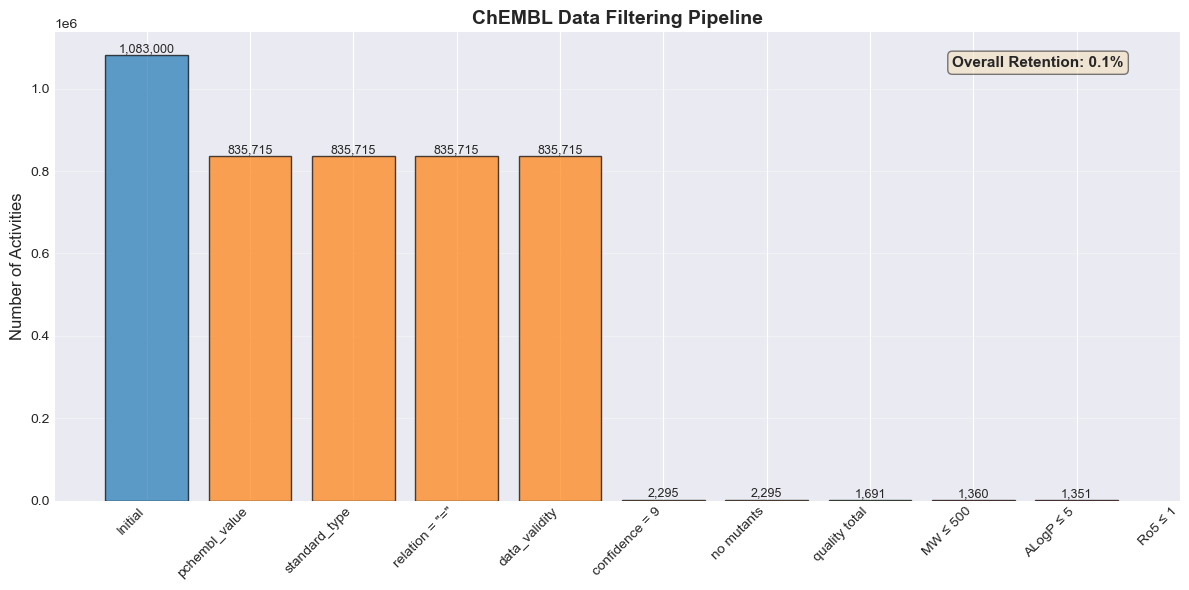

In [77]:
# Create filtering waterfall chart
fig, ax = plt.subplots(figsize=(12, 6))

stages = list(filter_stats.keys())
values = list(filter_stats.values())
labels = [
    'Initial',
    'pchembl_value',
    'standard_type',
    'relation = "="',
    'data_validity',
    'confidence = 9',
    'no mutants',
    'quality total',
    'MW ≤ 500',
    'ALogP ≤ 5',
    'Ro5 ≤ 1'
]

# Bar plot
colors = ['#1f77b4'] + ['#ff7f0e']*6 + ['#2ca02c'] + ['#d62728']*3
bars = ax.bar(range(len(values)), values, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}',
            ha='center', va='bottom', fontsize=9)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Number of Activities', fontsize=12)
ax.set_title('ChEMBL Data Filtering Pipeline', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add retention percentage annotation
retention = (values[-1] / values[0] * 100)
ax.text(0.95, 0.95, f'Overall Retention: {retention:.1f}%',
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (0,) and arg 1 with shape (2,).

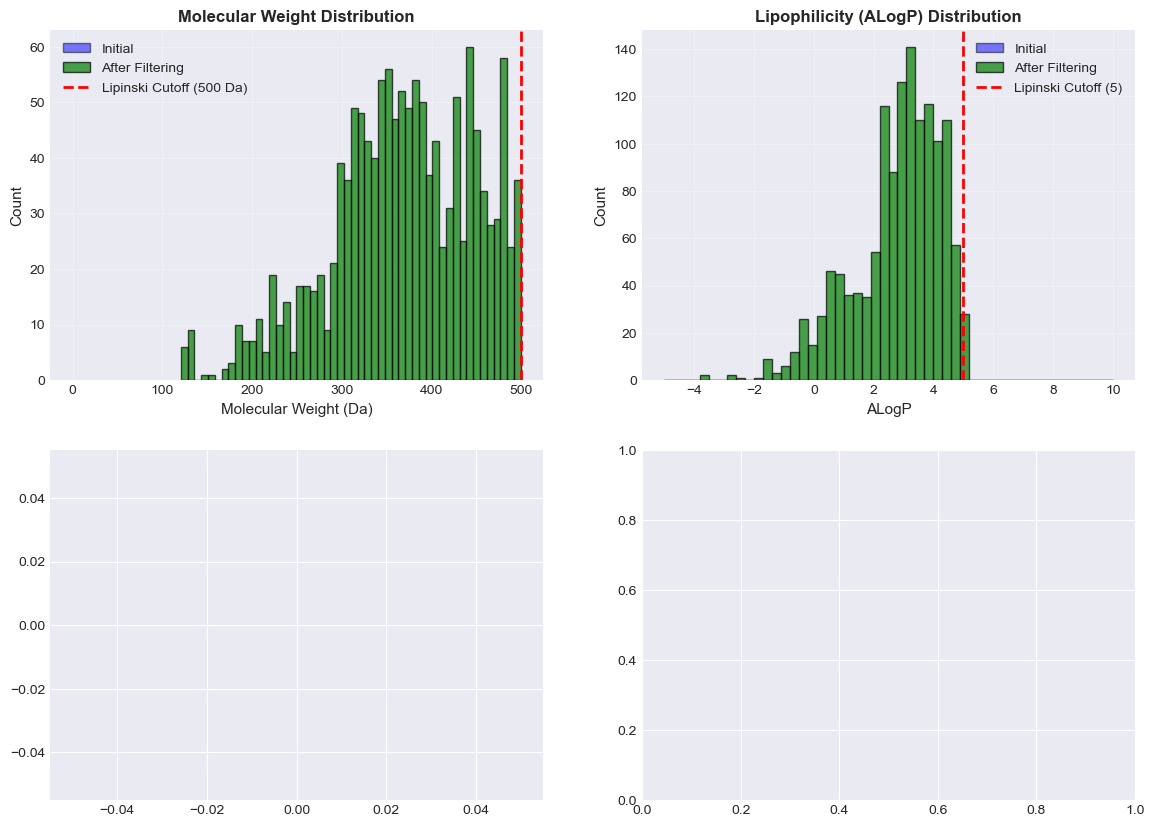

In [78]:
# Visualize Lipinski properties distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Molecular Weight distribution
ax = axes[0, 0]
ax.hist(df_all['molecular_weight'].dropna(), bins=50, alpha=0.5, label='Initial', color='blue', edgecolor='black')
ax.hist(df_lipinski['molecular_weight'].dropna(), bins=50, alpha=0.7, label='After Filtering', color='green', edgecolor='black')
ax.axvline(500, color='red', linestyle='--', linewidth=2, label='Lipinski Cutoff (500 Da)')
ax.set_xlabel('Molecular Weight (Da)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Molecular Weight Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# ALogP distribution
ax = axes[0, 1]
ax.hist(df_all['alogp'].dropna(), bins=50, alpha=0.5, label='Initial', color='blue', edgecolor='black', range=(-5, 10))
ax.hist(df_lipinski['alogp'].dropna(), bins=50, alpha=0.7, label='After Filtering', color='green', edgecolor='black', range=(-5, 10))
ax.axvline(5, color='red', linestyle='--', linewidth=2, label='Lipinski Cutoff (5)')
ax.set_xlabel('ALogP', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Lipophilicity (ALogP) Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Rule of 5 violations
ax = axes[1, 0]
ro5_initial = df_all['num_ro5_violations'].value_counts().sort_index()
ro5_final = df_lipinski['num_ro5_violations'].value_counts().sort_index()
x = np.arange(len(ro5_initial))
width = 0.35
ax.bar(x - width/2, ro5_initial.values, width, label='Initial', alpha=0.7, color='blue', edgecolor='black')
ax.bar(x + width/2, ro5_final.values, width, label='After Filtering', alpha=0.7, color='green', edgecolor='black')
ax.set_xlabel('Number of Ro5 Violations', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Rule of 5 Violations', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ro5_initial.index)
ax.legend()
ax.grid(alpha=0.3)

# Standard type distribution
ax = axes[1, 1]
std_type_final = df_lipinski['standard_type'].value_counts()
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(std_type_final)))
wedges, texts, autotexts = ax.pie(std_type_final.values, labels=std_type_final.index, autopct='%1.1f%%',
                                    colors=colors_pie, startangle=90, textprops={'fontsize': 10})
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
ax.set_title('Standard Type Distribution (Final)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Save Filtered Dataset

In [ ]:
# Save filtered dataset to parquet
print("Saving filtered dataset...")
df_lipinski.to_parquet(output_file, index=False)
print(f"✓ Filtered data saved to: {output_file}")
print(f"  File size: {output_file.stat().st_size / 1e6:.1f} MB")
print(f"  Total records: {len(df_lipinski):,}")

# Save summary statistics to JSON
summary_file = output_file.parent / 'filtering_summary.json'
summary_data = {
    'filtering_date': pd.Timestamp.now().isoformat(),
    'input_directory': str(raw_data_dir),
    'output_file': str(output_file),
    'filter_stages': filter_stats,
    'final_statistics': {
        'total_activities': len(df_lipinski),
        'unique_compounds': int(df_lipinski['molecule_chembl_id'].nunique()),
        'unique_uniprot_ids': int(df_lipinski['source_uniprot_id'].nunique()),
        'unique_assays': int(df_lipinski['assay_chembl_id'].nunique()),
        'unique_targets': int(df_lipinski['target_chembl_id'].nunique()),
        'standard_type_distribution': df_lipinski['standard_type'].value_counts().to_dict()
    },
    'quality_filters': {
        'pchembl_value': 'not null',
        'standard_type': ['IC50', 'Ki', 'Kd', 'EC50'],
        'standard_relation': '=',
        'data_validity_comment': 'null',
        'confidence_score': 9,
        'mutants_variants': 'excluded'
    },
    'lipinski_filters': {
        'molecular_weight': '≤ 500 Da',
        'alogp': '≤ 5',
        'num_ro5_violations': '≤ 1'
    },
    'retention_rate': {
        'quality_filtering': f"{len(df_filtered)/len(df_all)*100:.2f}%",
        'lipinski_filtering': f"{len(df_lipinski)/len(df_filtered)*100:.2f}%",
        'overall': f"{len(df_lipinski)/len(df_all)*100:.2f}%"
    }
}

with open(summary_file, 'w') as f:
    json.dump(summary_data, f, indent=2)

print(f"✓ Summary saved to: {summary_file}")

# Also save as CSV for easy viewing
csv_summary = summary.copy()
csv_file = output_file.parent / 'filtering_statistics.csv'
csv_summary.to_csv(csv_file, index=False)
print(f"✓ Statistics table saved to: {csv_file}")

Saving filtered dataset...
✓ Filtered data saved to: data/chembl_filtered.parquet
  File size: 0.0 MB
  Total records: 0
✓ Summary saved to: data/filtering_summary.json
✓ Statistics table saved to: data/filtering_statistics.csv


## 9. Per-UniProt Summary

Analyze how many compounds and activities remain for each UniProt ID after filtering.

In [ ]:
# Create per-UniProt summary
per_uniprot = df_lipinski.groupby('source_uniprot_id').agg({
    'activity_id': 'count',
    'molecule_chembl_id': 'nunique',
    'assay_chembl_id': 'nunique',
    'target_pref_name': 'first',
    'standard_type': lambda x: x.value_counts().to_dict()
}).rename(columns={
    'activity_id': 'num_activities',
    'molecule_chembl_id': 'num_unique_compounds',
    'assay_chembl_id': 'num_unique_assays',
    'target_pref_name': 'target_name',
    'standard_type': 'standard_type_distribution'
})

per_uniprot = per_uniprot.sort_values('num_activities', ascending=False)

print(f"Per-UniProt Summary (Top 20 by activity count):")
display(per_uniprot.head(20))

# Save per-UniProt summary
per_uniprot_file = output_file.parent / 'per_uniprot_summary.csv'
per_uniprot_simple = per_uniprot.drop('standard_type_distribution', axis=1)
per_uniprot_simple.to_csv(per_uniprot_file)
print(f"\n✓ Per-UniProt summary saved to: {per_uniprot_file}")

Per-UniProt Summary (Top 20 by activity count):


,num_activities,num_unique_compounds,num_unique_assays,target_name,standard_type_distribution
source_uniprot_id,,,,,



✓ Per-UniProt summary saved to: data/per_uniprot_summary.csv


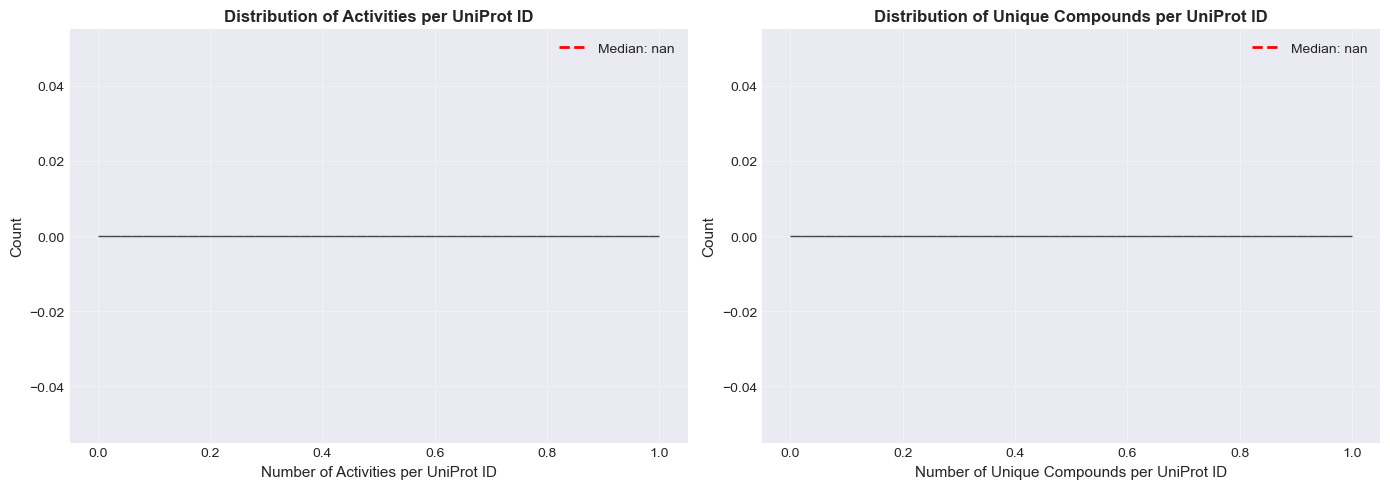


Per-UniProt Statistics:
  Median activities per UniProt: nan
  Mean activities per UniProt: nan
  Median compounds per UniProt: nan
  Mean compounds per UniProt: nan


In [ ]:
# Visualize per-UniProt distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Activities per UniProt
ax = axes[0]
activities_dist = per_uniprot['num_activities'].values
ax.hist(activities_dist, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Number of Activities per UniProt ID', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of Activities per UniProt ID', fontsize=12, fontweight='bold')
ax.axvline(np.median(activities_dist), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(activities_dist):.0f}')
ax.legend()
ax.grid(alpha=0.3)

# Compounds per UniProt
ax = axes[1]
compounds_dist = per_uniprot['num_unique_compounds'].values
ax.hist(compounds_dist, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax.set_xlabel('Number of Unique Compounds per UniProt ID', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of Unique Compounds per UniProt ID', fontsize=12, fontweight='bold')
ax.axvline(np.median(compounds_dist), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(compounds_dist):.0f}')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPer-UniProt Statistics:")
print(f"  Median activities per UniProt: {np.median(activities_dist):.0f}")
print(f"  Mean activities per UniProt: {np.mean(activities_dist):.1f}")
print(f"  Median compounds per UniProt: {np.median(compounds_dist):.0f}")
print(f"  Mean compounds per UniProt: {np.mean(compounds_dist):.1f}")

## 10. Final Summary

All filtering complete! The filtered dataset is ready for downstream analysis.

In [ ]:
print("="*80)
print("FILTERING PIPELINE COMPLETE")
print("="*80)
print(f"\n✓ Input: {len(activity_files)} UniProt activity files from data/raw/")
print(f"✓ Output: {output_file}")
print(f"\n📊 Final Dataset Statistics:")
print(f"  • Total activities: {len(df_lipinski):,}")
print(f"  • Unique compounds: {df_lipinski['molecule_chembl_id'].nunique():,}")
print(f"  • Unique UniProt IDs: {df_lipinski['source_uniprot_id'].nunique():,}")
print(f"  • Unique assays: {df_lipinski['assay_chembl_id'].nunique():,}")
print(f"  • Unique targets: {df_lipinski['target_chembl_id'].nunique():,}")

print(f"\n🎯 Quality Filters Applied:")
print(f"  • pchembl_value: not null")
print(f"  • standard_type: IC50, Ki, Kd, EC50")
print(f"  • standard_relation: = (exact)")
print(f"  • data_validity: valid")
print(f"  • confidence_score: 9 (high confidence)")
print(f"  • mutants/variants: excluded")

print(f"\n💊 Lipinski's Rule of 5 Filters Applied:")
print(f"  • Molecular Weight ≤ 500 Da")
print(f"  • ALogP ≤ 5")
print(f"  • Ro5 violations ≤ 1")

print(f"\n📈 Retention Rates:")
print(f"  • After quality filtering: {len(df_filtered)/len(df_all)*100:.1f}%")
print(f"  • After Lipinski filtering: {len(df_lipinski)/len(df_filtered)*100:.1f}%")
print(f"  • Overall retention: {len(df_lipinski)/len(df_all)*100:.1f}%")

print(f"\n📁 Output Files:")
print(f"  • Filtered data: {output_file}")
print(f"  • Summary JSON: {summary_file}")
print(f"  • Statistics CSV: {csv_file}")
print(f"  • Per-UniProt summary: {per_uniprot_file}")

print(f"\n✅ Pipeline complete! Ready for downstream analysis.")

FILTERING PIPELINE COMPLETE

✓ Input: 361 UniProt activity files from data/raw/
✓ Output: data/chembl_filtered.parquet

📊 Final Dataset Statistics:
  • Total activities: 0
  • Unique compounds: 0
  • Unique UniProt IDs: 0
  • Unique assays: 0
  • Unique targets: 0

🎯 Quality Filters Applied:
  • pchembl_value: not null
  • standard_type: IC50, Ki, Kd, EC50
  • standard_relation: = (exact)
  • data_validity: valid
  • confidence_score: 9 (high confidence)
  • mutants/variants: excluded

💊 Lipinski's Rule of 5 Filters Applied:
  • Molecular Weight ≤ 500 Da
  • ALogP ≤ 5
  • Ro5 violations ≤ 1

📈 Retention Rates:
  • After quality filtering: 77.2%
  • After Lipinski filtering: 0.0%
  • Overall retention: 0.0%

📁 Output Files:
  • Filtered data: data/chembl_filtered.parquet
  • Summary JSON: data/filtering_summary.json
  • Statistics CSV: data/filtering_statistics.csv
  • Per-UniProt summary: data/per_uniprot_summary.csv

✅ Pipeline complete! Ready for downstream analysis.
